# Summary

Dans ce notebook, nous allons mettre en pratique les algorithmes de regression sur un jeu de données relatif aux prix de biens immobilliers à Ames, Iowa.

Pour rappel, voici **quelques étapes de travail** d'un **Data Scientist** sont les suivantes:

<img src=attachment:f51f71af-8592-414e-a490-2c6d3bbcfe46.png width=700>


**Outils:**
- **Collecte et exploration des données**: pandas, polar, missingno, ydata-profiling, seaborn, plotly, ...
- **Modélisaion**: lazypredict sklearn, xgboost, lightgbm, catboost, yellowbricks, ...
- **Optimisation des hyperparamètres**: gridsearch (sklearn), optuna, hyperopt, ...
- **Déploiement**: mlflow, fastapi, evidently, heroku, pythonanywhere, azure webapp, ...

# Sources utiles

- [Introduction à MLOps](https://ashutoshtripathi.com/2021/08/18/mlops-a-complete-guide-to-machine-learning-operations-mlops-vs-devops/)

- [MLFLOW - Site de référence](https://mlflow.org/docs/latest/index.html)
- [MLFLOW - Tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html)
- [MLFLOW - Tracking](https://mlflow.org/docs/latest/tracking.html)
- [MLFLOW - Model Registry](https://mlflow.org/docs/latest/model-registry.html#)
- [MLFLOW - Serve a model](https://mlflow.org/docs/latest/model-registry.html#serving-an-mlflow-model-from-model-registry)

- [Evidently - tutorial d'analyse de Data drift](https://github.com/evidentlyai/evidently/tree/main/examples/sample_notebooks)
- [API Flask - Démarche de mise en oeuvre](http://web.univ-ubs.fr/lmba/lardjane/python/c4.pdf)
- [FastAPI - Démarche de mise en oeuvre](https://towardsdatascience.com/how-to-build-and-deploy-a-machine-learning-model-with-fastapi-64c505213857)
- [Azure - Tuto déploiement application web ](https://learn.microsoft.com/fr-fr/azure/app-service/quickstart-python?tabs=flask%2Cwindows%2Cazure-portal%2Cvscode-deploy%2Cdeploy-instructions-azportal%2Cterminal-bash%2Cdeploy-instructions-zip-azcli)
- [Tests unitaires - Unittest ou Pytest](https://www.sitepoint.com/python-unit-testing-unittest-pytest/)

- [Pythonanywhere](https://www.pythonanywhere.com/)
- [Heroku](https://www.heroku.com/)
-[Azure webapp - Déploiement automatisé via Github](https://learn.microsoft.com/fr-fr/azure/app-service/deploy-continuous-deployment?tabs=github)
- Streamlit ou gradio pour la mise en place d'un dashbord


In [1]:
!pip3 install dill matplotlib missingno pandas seaborn optuna plotly pendulum loguru yellowbrick ydata_profiling

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
!python3 -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# Librairies

In [1]:
# reload modules before executing user code.
#%reload_ext autoreload
#%autoreload 2

import sys
from pathlib import Path
import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import pendulum
import seaborn as sns
from loguru import logger
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot


sys.path.append(str(Path.cwd().parent))
from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             TIMEZONE,
                            )
from src.make_dataset import load_data


set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", None)

/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [2]:
# time in UTC
log_fmt = ("<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
          )
log_config = {
    "handlers": [
        {"sink": sys.stderr, "format": log_fmt},
    ],
}
logger.configure(**log_config)


[1]

In [3]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)

logger.info(f"Execution date: {EXECUTION_DATE}")

logger.info(f"\nData input directory : {DATA_DIR_INPUT}\nData output directory: {DATA_DIR_OUTPUT}")


# model parameters
FEATURES = MODEL_PARAMS.get("FEATURES")
TARGET_NAME = MODEL_PARAMS["TARGET"]

2023-08-21 14:39:20.465 | INFO     | __main__:<module>:3 - Execution date: 2023-08-21T14:39:20.463245+00:00
2023-08-21 14:39:20.468 | INFO     | __main__:<module>:5 - 
Data input directory : /home/dosecurity/Desktop/PythonProjects/ProjectFolder/mlops-project-dic3/data/input
Data output directory: /home/dosecurity/Desktop/PythonProjects/ProjectFolder/mlops-project-dic3/data/output


# Data Collection

In [4]:
data = pd.read_csv(str(DATA_DIR_INPUT) + "/train.csv.zip")

In [5]:
data.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [7]:
data.columns

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue'],
      dtype='object')

### Variables quantitatives

In [8]:
data.describe(include="int")

,Id,P1,P5,P6,P7,P8,P9,P10,P11,P12,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P30,P31,P32,P33,P34,P35,P36,P37
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,68.000000,4.014599,2.007299,3.357664,5.423358,5.153285,5.445255,5.489051,3.262774,5.299270,1.416058,1.386861,1.941606,1.036496,1.941606,4.905109,4.547445,2.270073,2.226277,3.423358,1.372263,1.211679,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788
std,39.692569,2.910391,1.209620,2.134235,2.296809,1.858567,1.834793,1.847561,1.910767,1.941668,2.729583,2.398677,3.505807,2.030679,3.300549,5.604467,3.708041,2.052630,1.230690,4.559609,2.304112,2.133179,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,2.000000,1.000000,2.000000,5.000000,4.000000,4.000000,5.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,3.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102.000000,4.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,1.000000,4.000000,5.000000,5.000000,3.000000,3.000000,5.000000,2.000000,2.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000
max,136.000000,12.000000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,15.000000,10.000000,15.000000,15.000000,12.000000,25.000000,15.000000,15.000000,5.000000,25.000000,10.000000,10.000000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000


### Variables catégorielles

In [9]:
data.describe(include="object")

,Open Date,City,City Group,Type
count,137,137,137,137
unique,134,34,2,3
top,02/23/2010,İstanbul,Big Cities,FC
freq,2,50,78,76


### features data

In [10]:
#data_features = data[MODEL_PARAMS['FEATURES']]

In [11]:
#data_features

### Verification de valeurs manquantes

In [12]:
data.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

Nous nous rendons compte qu'il n'y a aucune valeur manquante dans le dataset

# EDA: Exploratory Data Analysis
### Partie exploratoire des donnees

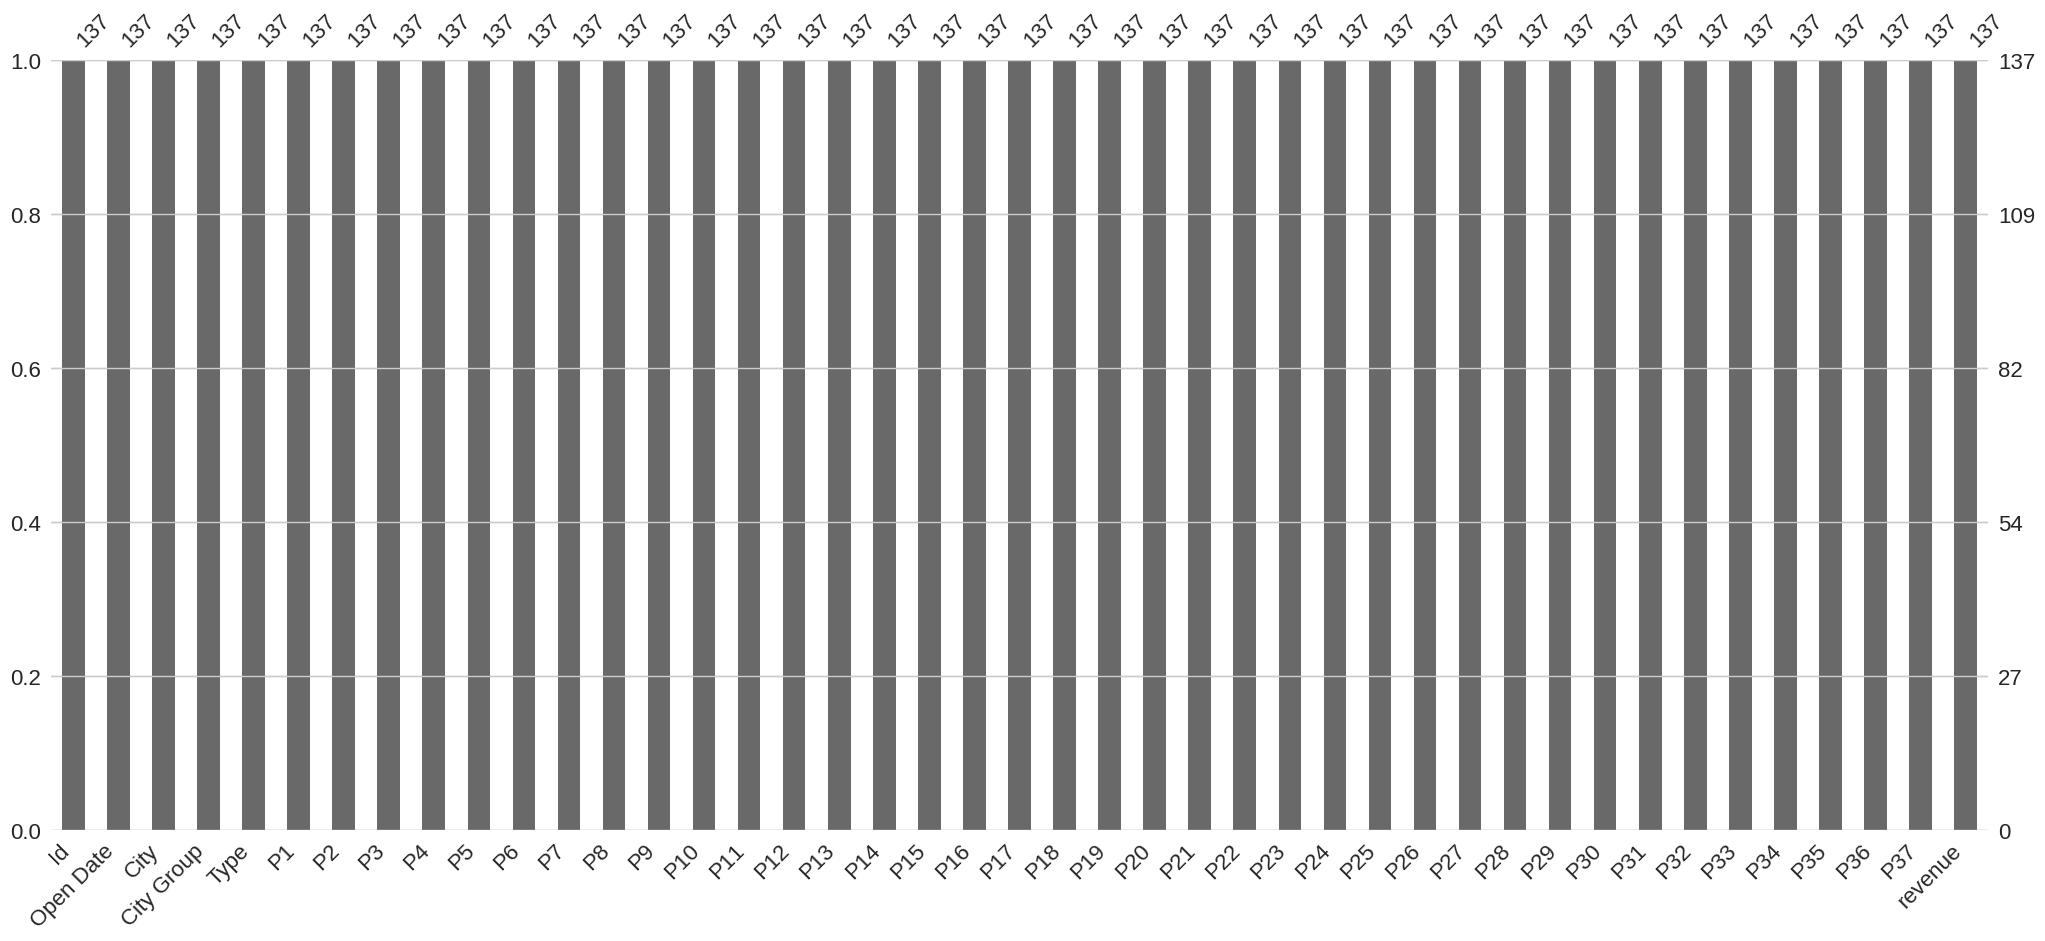

In [13]:
msno.bar(data,
         filter="top" # filter columns with % of missing values > 50%
        );

Ce diagramme vient confirmer, notre conslusion sur le fait qu'il n'y avait pas de donnees manquantes dans le dataset

### Variable cible

##### Description

In [14]:
# Target: stat description
data[TARGET_NAME].describe()

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64

##### Distribution de la densite

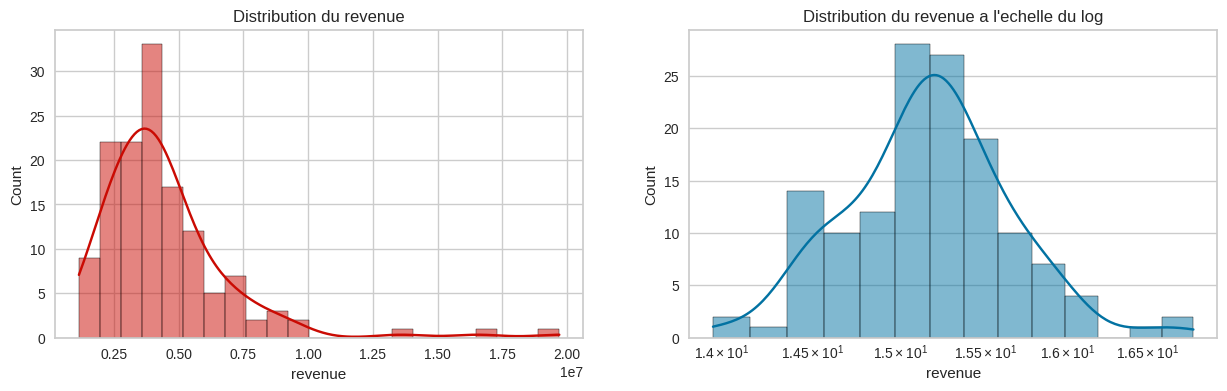

In [15]:
# Target distribution: raw vs log (box-cox transformation)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data[TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution du revenue')

sns.histplot(np.log(data[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution du revenue a l\'echelle du log')
axes[1].set_xscale('log')

Nous voyons que la variable cible est tres assymetrique. Cette assymetrie est due a des valeurs extremes qui indiquent des revenues avec de gros ecarts entre les differents restaurants

###     Exploration des features

Passons a l'exploration des features

- La Variable Type: Type du restaurant

In [16]:
data.Type.describe()

count     137
unique      3
top        FC
freq       76
Name: Type, dtype: object

In [17]:
data.Type.unique()


array(['IL', 'FC', 'DT'], dtype=object)

<Axes: xlabel='Type', ylabel='count'>

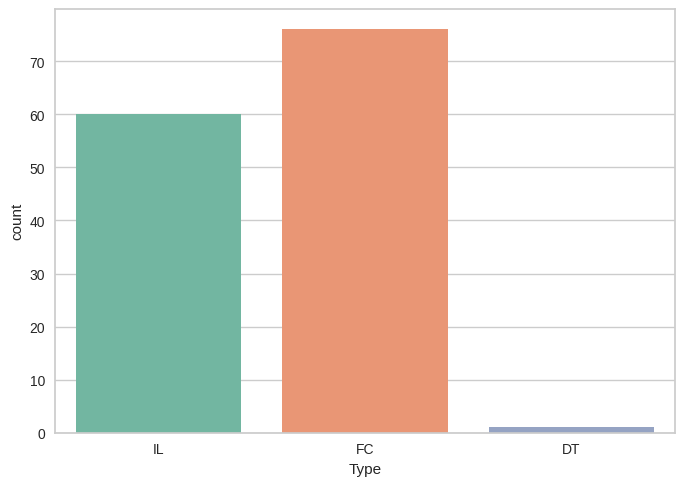

In [18]:
sns.countplot(x=data.Type, data=data, palette="Set2")

Le nombre de "DT" (drive-thru) est très faible, ce qui indique que ces deux types de restaurants sont les moins appréciés, tandis que "FC" (Food Court) est le type de restaurant le plus apprécié.

- La Variable City: Ville dans laquelle le restaurant est situe

In [19]:
data.City.describe()

count          137
unique          34
top       İstanbul
freq            50
Name: City, dtype: object

In [20]:
data.City.unique()

array(['İstanbul', 'Ankara', 'Diyarbakır', 'Tokat', 'Gaziantep',
       'Afyonkarahisar', 'Edirne', 'Kocaeli', 'Bursa', 'İzmir', 'Sakarya',
       'Elazığ', 'Kayseri', 'Eskişehir', 'Şanlıurfa', 'Samsun', 'Adana',
       'Antalya', 'Kastamonu', 'Uşak', 'Muğla', 'Kırklareli', 'Konya',
       'Karabük', 'Tekirdağ', 'Denizli', 'Balıkesir', 'Aydın', 'Amasya',
       'Kütahya', 'Bolu', 'Trabzon', 'Isparta', 'Osmaniye'], dtype=object)

<Axes: xlabel='City', ylabel='count'>

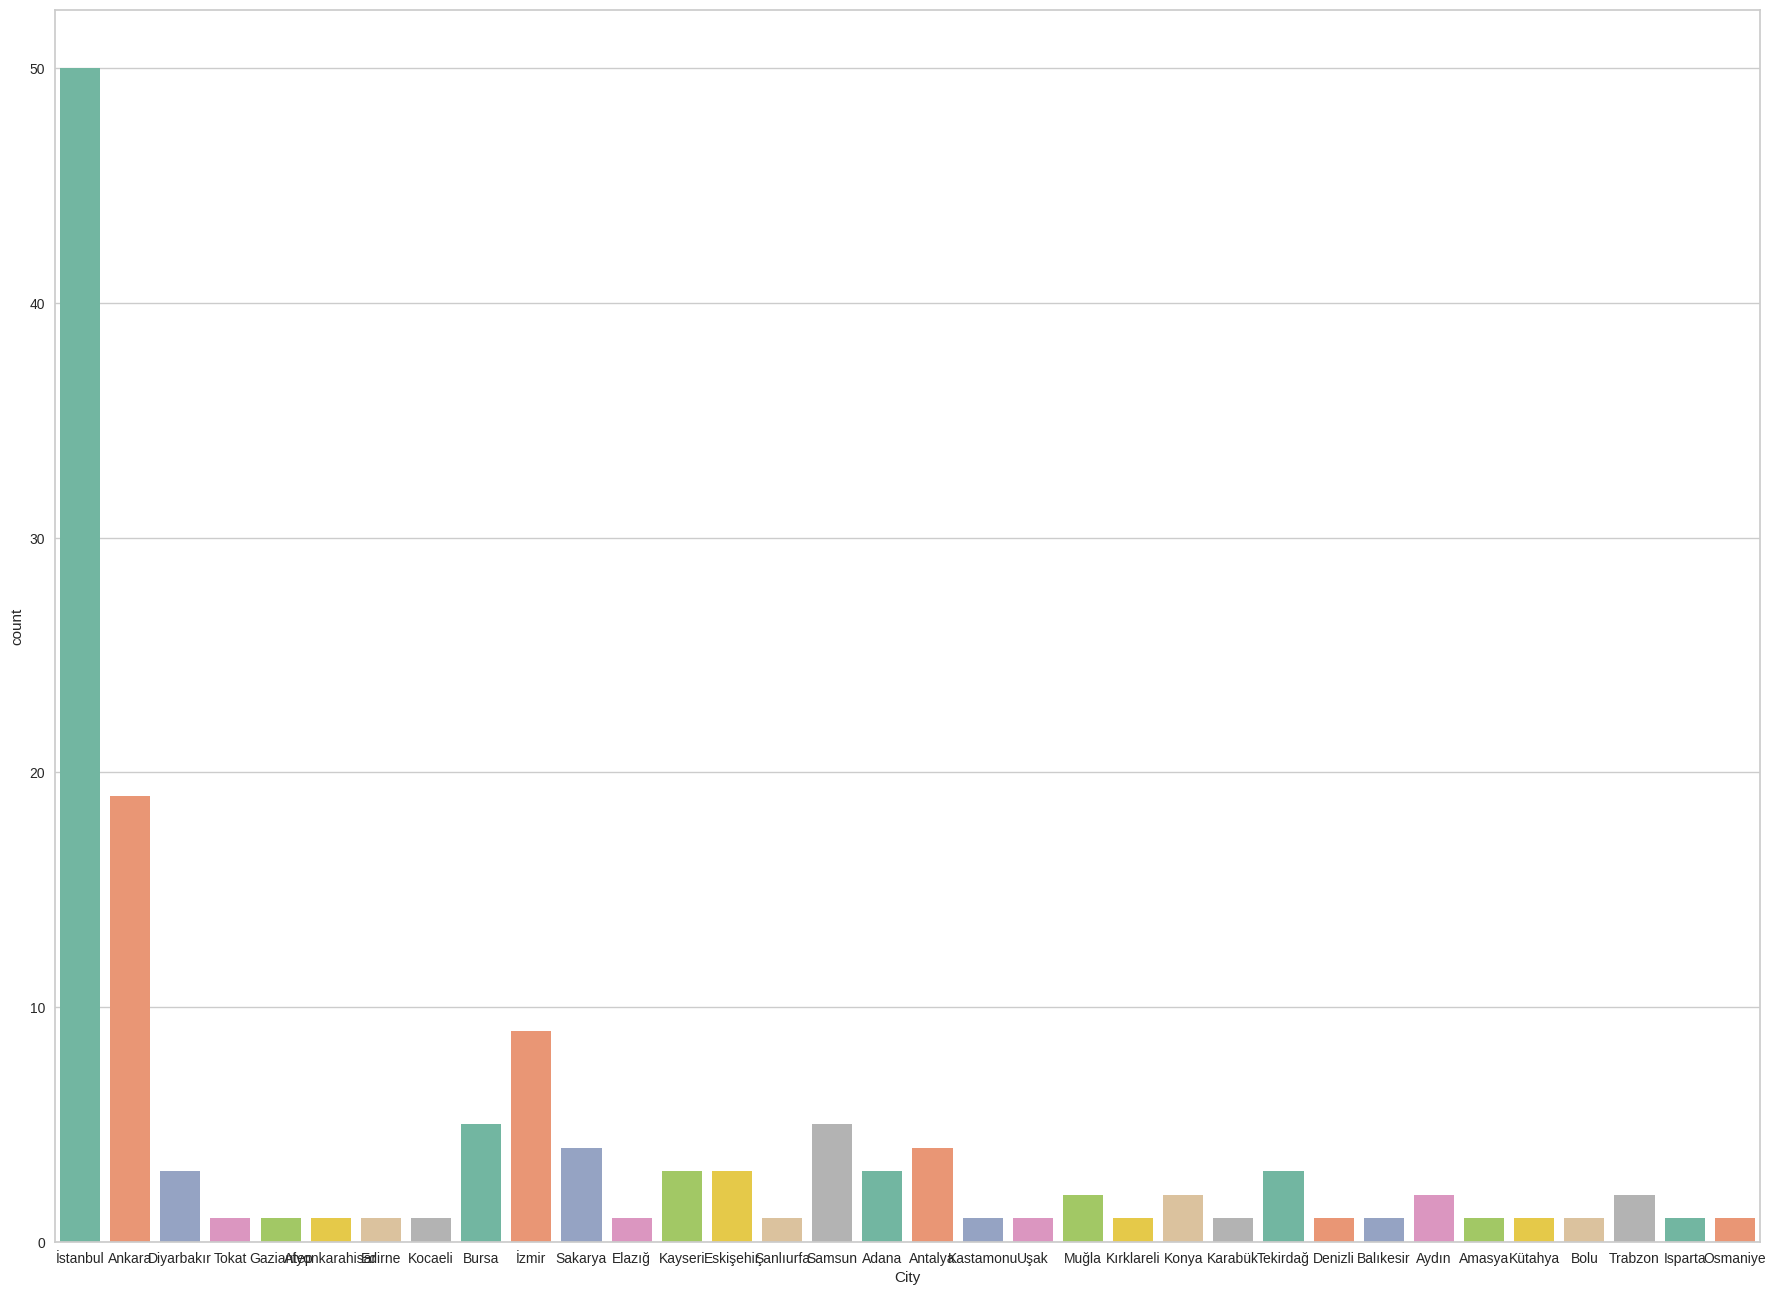

In [21]:
plt.figure(figsize=(22,16))
sns.countplot(x=data.City, data=data, palette="Set2")

In [22]:
counts = data['City'].value_counts() #counts unique values
percent = ((data['City'].value_counts()/data['City'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(5)

,count,percentage
City,,
İstanbul,50,36.5%
Ankara,19,13.9%
İzmir,9,6.6%
Bursa,5,3.6%
Samsun,5,3.6%


Pres de 60% des restaurants sont ouverts dans les villes comme Istanbul,Ankara, Izmir. Ce qui justfie l'allure de notre graphe sur les villes

- La Variable City Group: Type de villes[Grande ville, autres

In [23]:
data['City Group'].describe()

count            137
unique             2
top       Big Cities
freq              78
Name: City Group, dtype: object

In [24]:
data['City Group'].unique()

array(['Big Cities', 'Other'], dtype=object)

<Axes: xlabel='City Group', ylabel='count'>

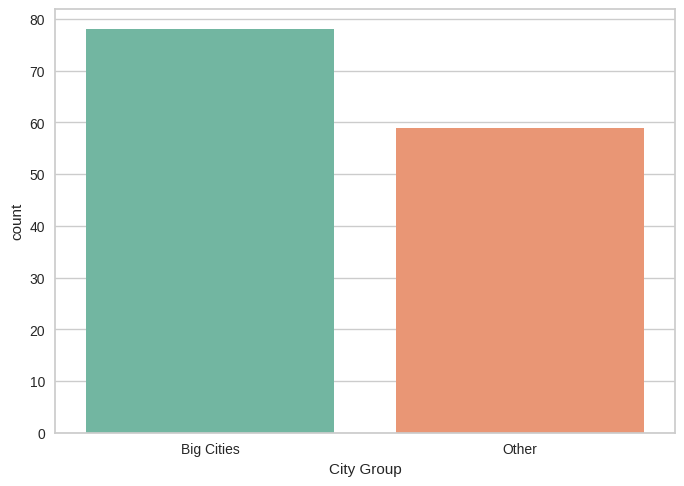

In [25]:
sns.countplot(x=data['City Group'], data=data, palette="Set2")

Ce  graphe nous montre que la majeur partie des restaurants ouverts de trouve dans des "Big cities"

### Etude de la distribution des feature en fonction de la variable revenue

- Type et revenue

<Axes: xlabel='Type', ylabel='revenue'>

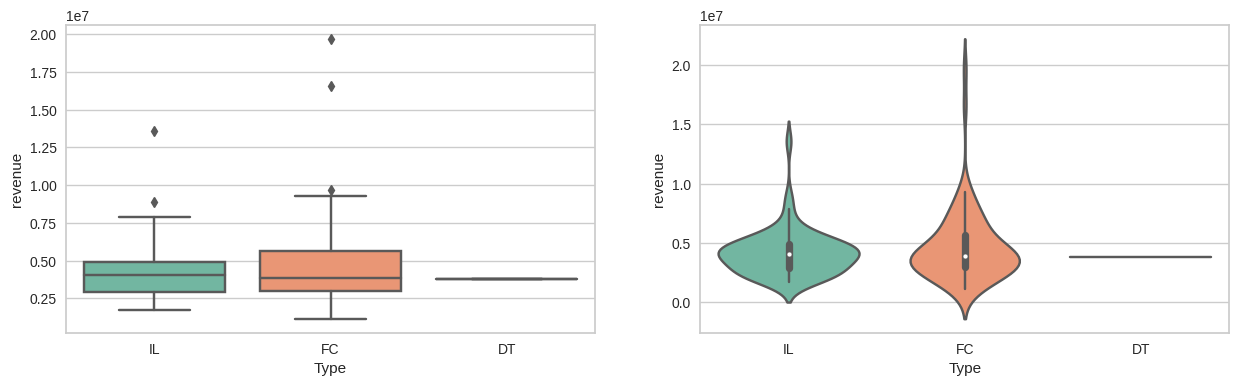

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.boxplot(x=data.Type, y=data.revenue, data=data, palette="Set2", ax=axes[0])
sns.violinplot(x=data.Type, y=data.revenue, data=data, palette="Set2", ax=axes[1])


Les restaurants "FC" (FoodCourt) et "IL" (Inline) sont les types de restaurants préférés, dont la distribution est similaire et qui génèrent également de bons revenus.

- City group et revenue

<Axes: xlabel='City Group', ylabel='revenue'>

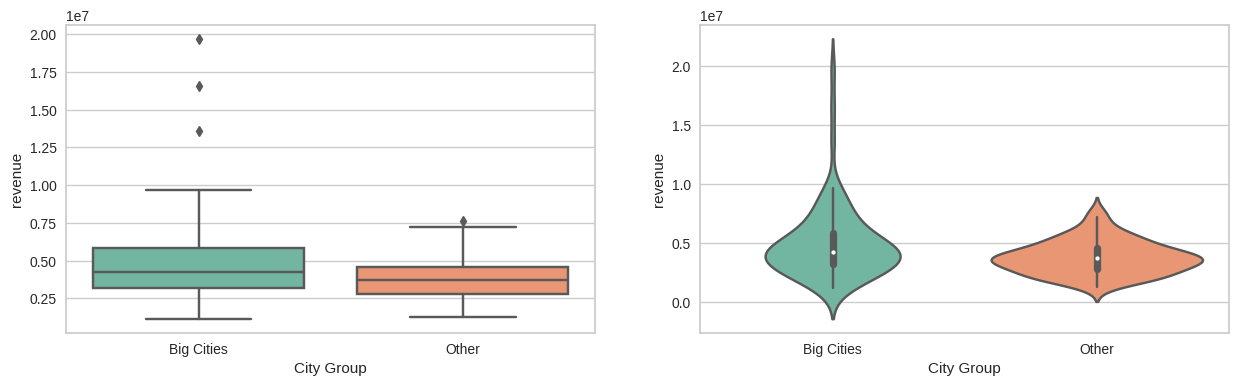

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.boxplot(x=data['City Group'], y=data.revenue, data=data, palette="Set2", ax=axes[0])
sns.violinplot(x=data['City Group'], y=data.revenue, data=data, palette="Set2", ax=axes[1])

Nous pouvons observer que quelques restaurants dans les "grandes villes" réalisent une marge de revenus plus élevée. Il est donc préférable d'ouvrir un nouveau restaurant dans les "grandes villes" pour obtenir des revenus élevés.

- City et revenue

Text(0, 0.5, 'City')

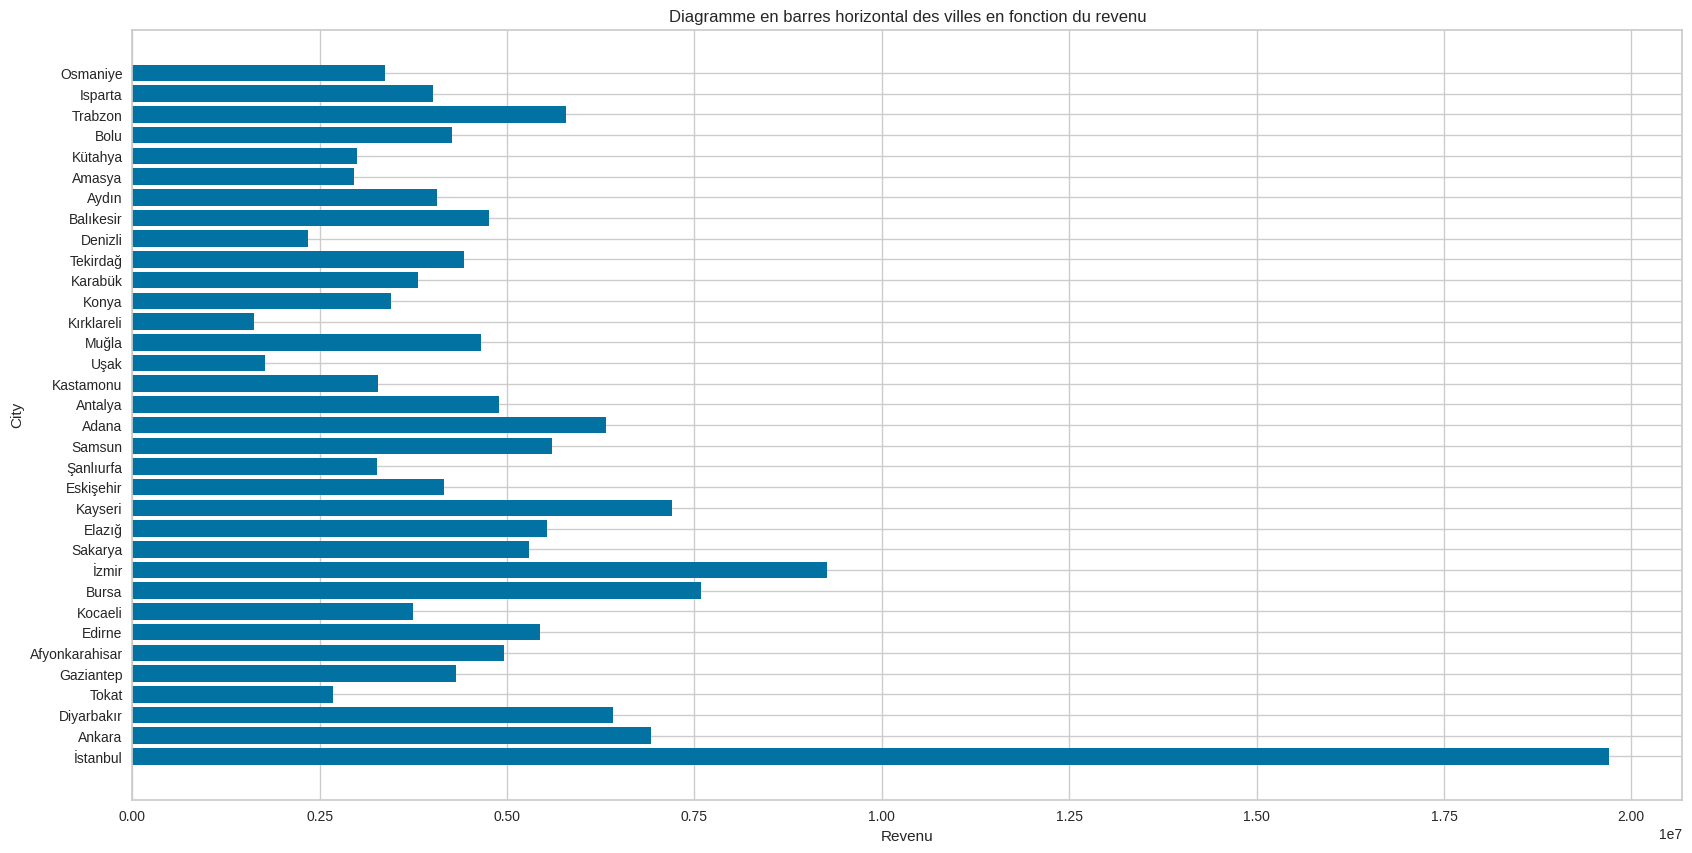

In [28]:
plt.figure(figsize=(20, 10))
plt.barh(data.City,data.revenue)
plt.title('Diagramme en barres horizontal des villes en fonction du revenu')
plt.xlabel('Revenu')
plt.ylabel('City')

Le restaurant en Istanbul est celui avec plus de revenue qui s'explique en partie par le fait qu'il est le plus represente au niveau du dataset

- Les variables demograpiques P1-P37:
Ce sont des donnees qui representent trois categories. 

Les données démographiques - comprennent la population d'une zone donnée, la répartition par âge et par sexe, les échelles de développement.

Les données immobilières - liées aux m2 de l'emplacement, à la façade de l'emplacement, à la disponibilité des parkings. 

Les données commerciales - y compris l'existence de points d'intérêt tels que les écoles, les banques, les autres opérateurs QSR.

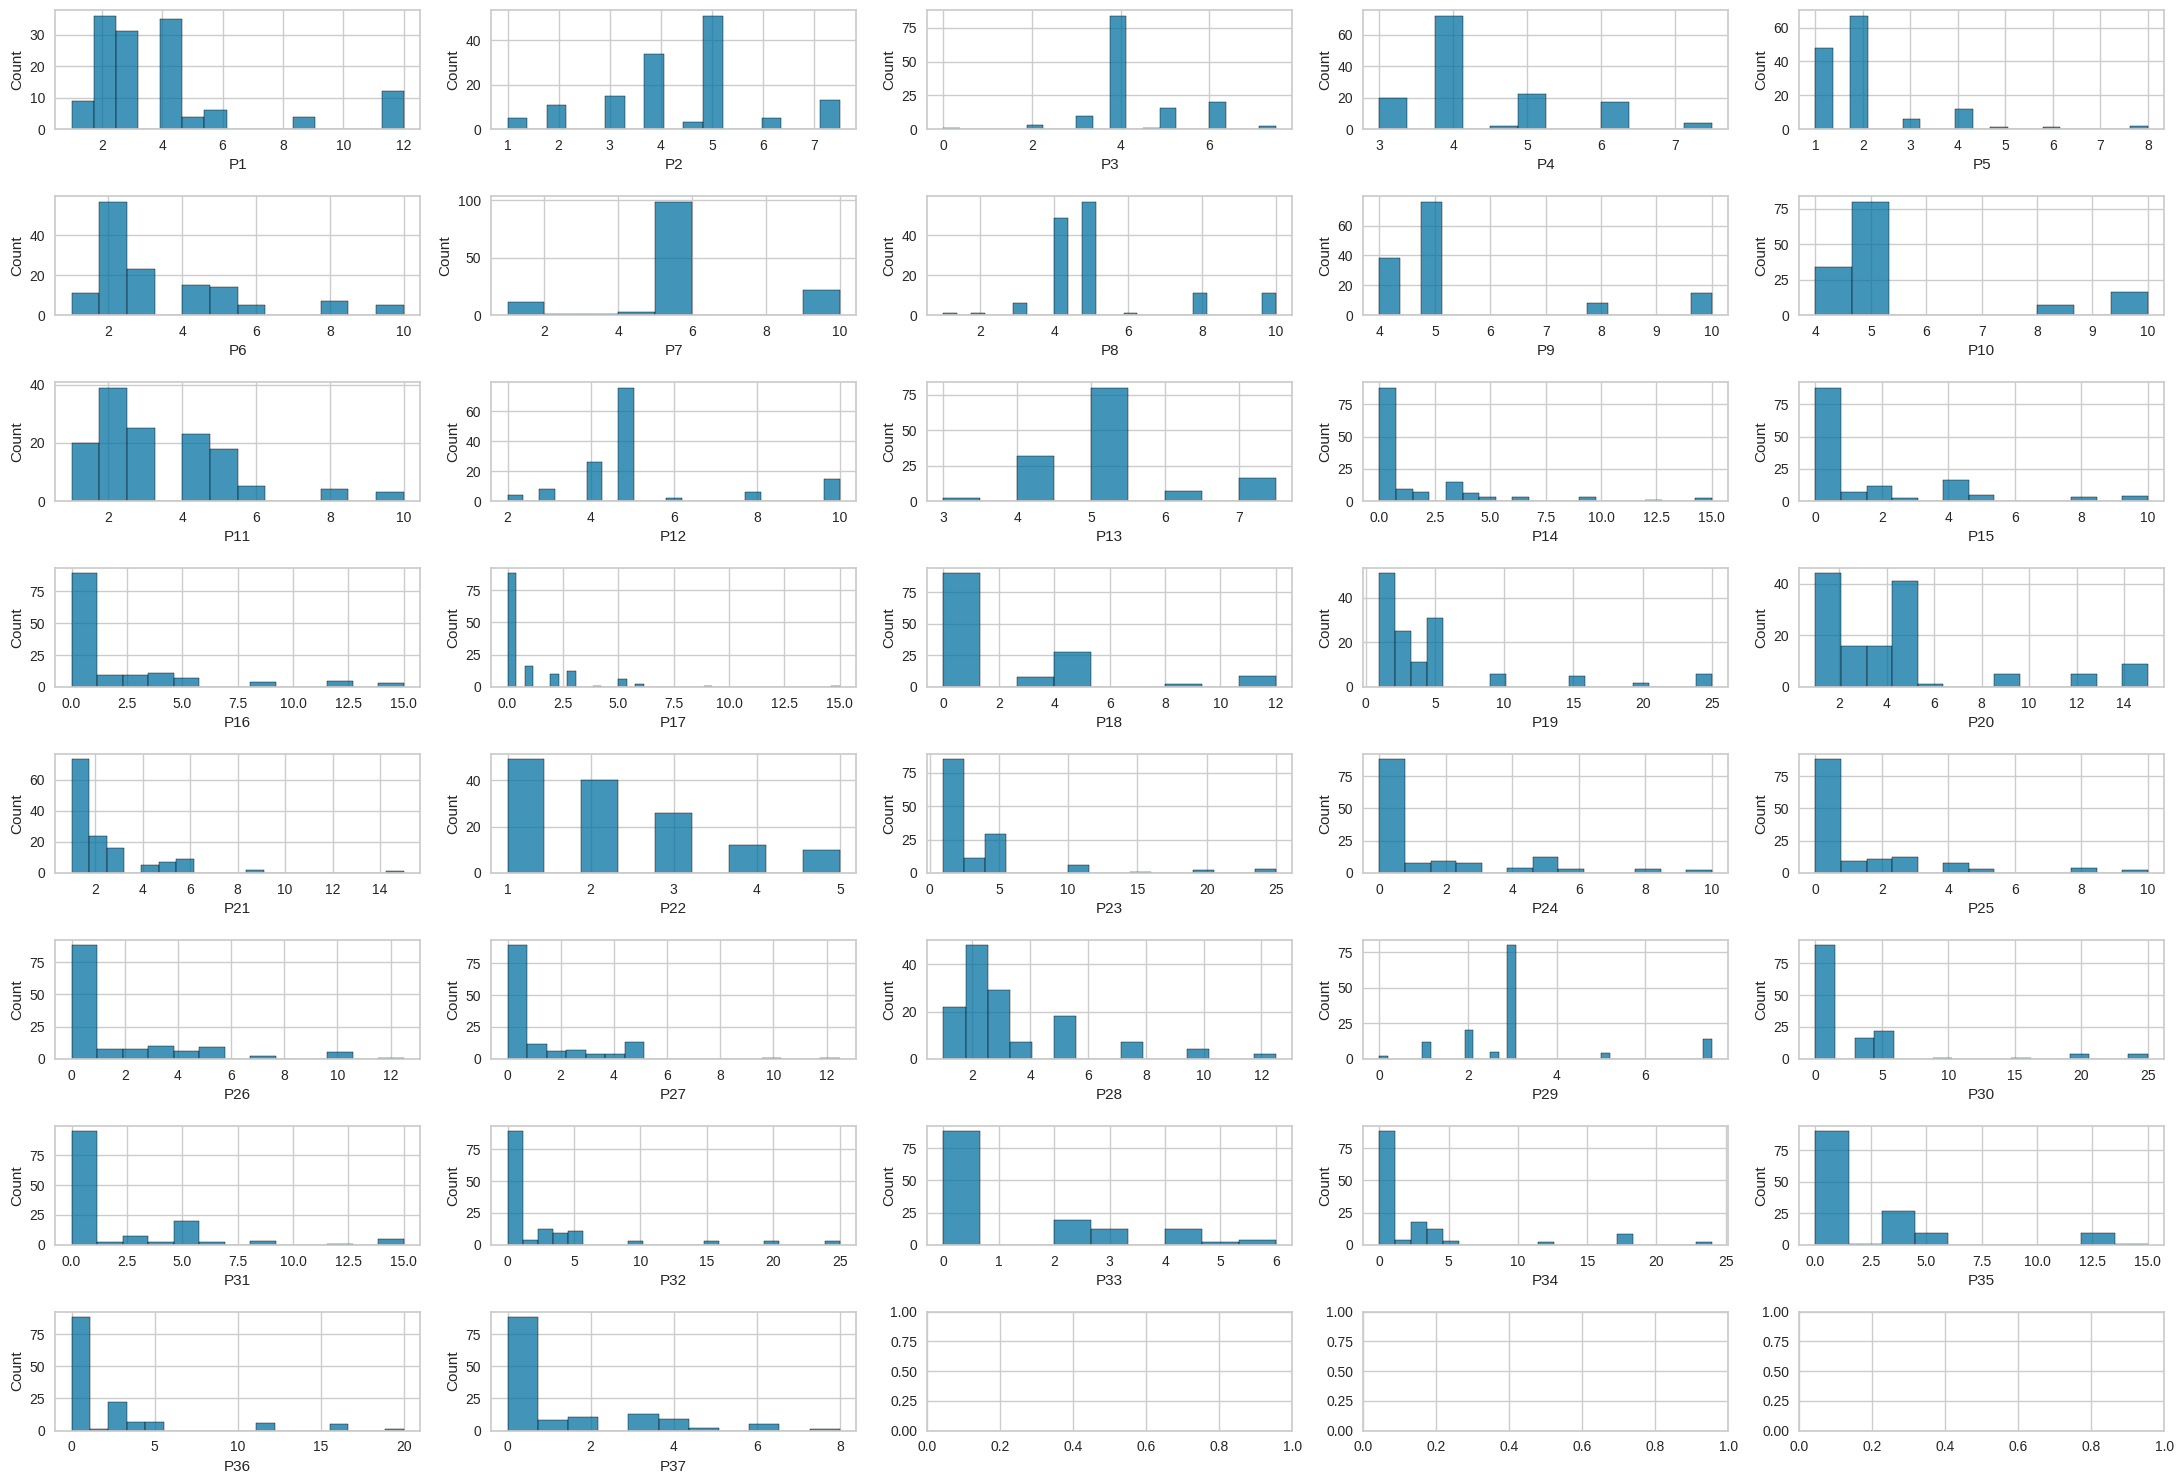

In [29]:
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(22, 15))
axes = axes.ravel()

# Parcourir les colonnes P1 à P37 et créer un histogramme pour chaque
for i in range(1, 38):
    ax = axes[i - 1]
    sns.histplot(data['P{}'.format(i)], kde=False, ax=ax)
    ax.set_xlabel('P{}'.format(i))

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()



### Feature Engineering

Dans cette partie, nous allons effectuer les transformations sur les donnees et identifier les key insights pour nos models

- Transformation de la variable 'OpenDate' en Year, Month et YearsOld qui seront de nouvelles colonnes

In [30]:
def newFeatures(df):
  df['Date'] = pd.to_datetime(df['Open Date'],format="%m/%d/%Y")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
  df = df.drop(['Open Date','Date'],axis=1)
  return df

In [31]:
data = newFeatures(data)

/tmp/ipykernel_171843/1154867233.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year


In [32]:
data

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,Years Old
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,16
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,7
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,2
3,3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,3
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5787594.0,2008,6,7
133,133,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,9262754.0,2006,10,9
134,134,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2544857.0,2006,7,9
135,135,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,7217634.0,2010,10,5


Nous voyons que les colonnes Year, Month, YearsOLd sont ajoutees dans le dataset alors que la colonne OpenDate est supprimee

- Suppression de la colonne ID

In [33]:
data.drop(["Id"], axis=1, inplace=True)

In [34]:
data

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,Years Old
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,16
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,7
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,2
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,3
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5787594.0,2008,6,7
133,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,9262754.0,2006,10,9
134,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2544857.0,2006,7,9
135,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,7217634.0,2010,10,5


- Distribution des nouvelles variables creees par rapport au revenue
    - Month

<Axes: xlabel='Month', ylabel='revenue'>

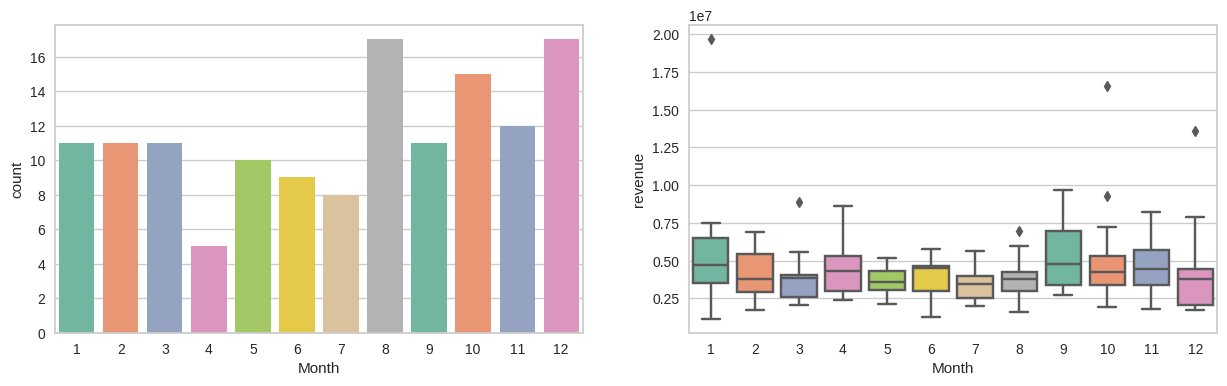

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.countplot(x=data.Month, data=data, palette="Set2", ax=axes[0])
sns.boxplot(x=data.Month, y=data.revenue, data=data, palette="Set2", ax=axes[1])

La plupart des nouveaux restaurants ouvrent leurs portes en août et en décembre.
Les restaurants enregistrent de bons revenus en avril, en septembre et en janvier.

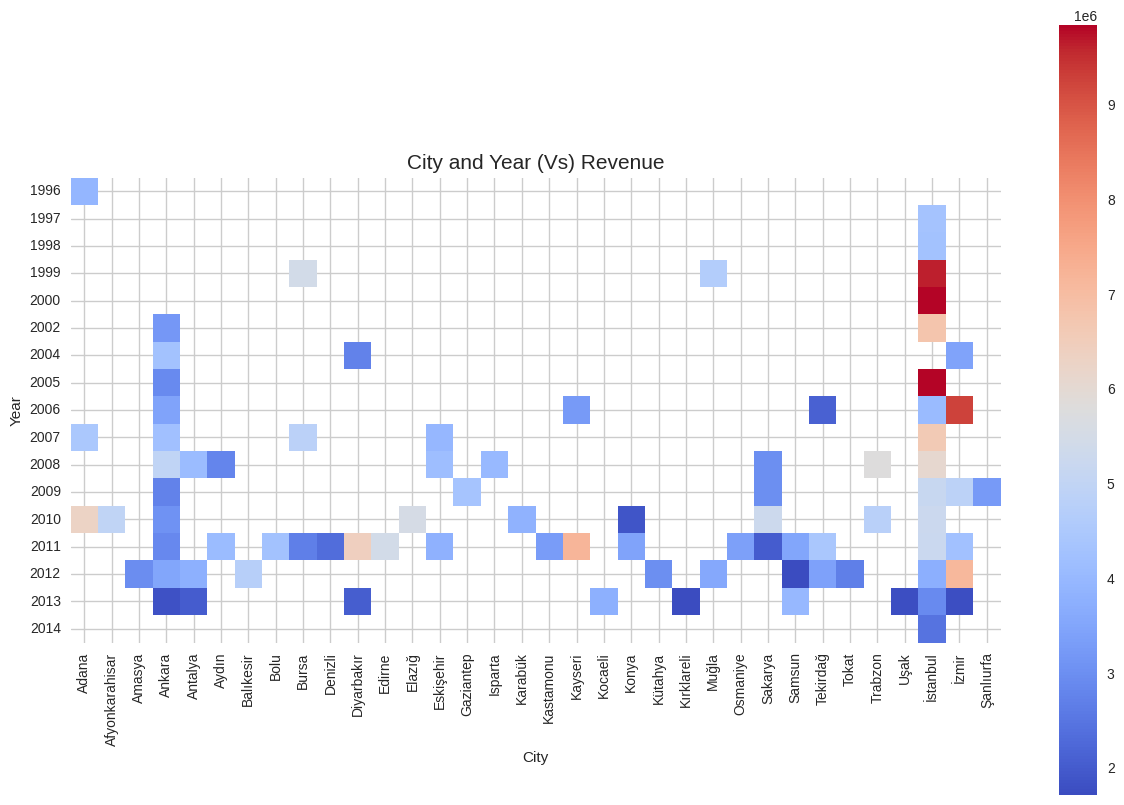

In [36]:
df = pd.DataFrame({'City':data['City'],'Year':data['Year'],'revenue':data['revenue']})

df_wide=df.pivot_table( index='Year', columns='City', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data in rect boxes
plt.title('City and Year (Vs) Revenue',size=15)
plt.show()

Le graphique ci-dessus montre que, parmi les autres villes, Istanbul est celle qui génère les revenus les plus élevés et que la plupart d'entre elles préfèrent ouvrir de nouveaux restaurants presque chaque année depuis 1997. Ankara et Izmir sont les villes qui génèrent de bons revenus et, après Istanbul, ce sont les villes les plus propices à l'ouverture d'un nouveau restaurant chaque année.

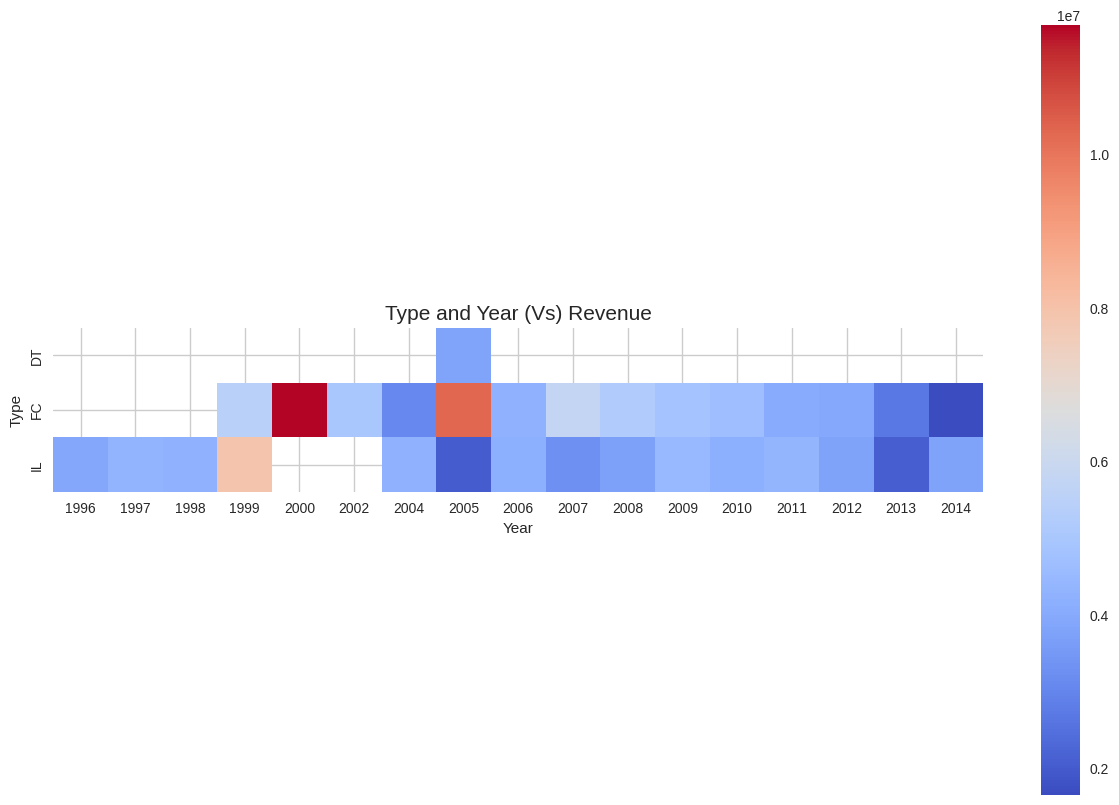

In [37]:
df = pd.DataFrame({'Type':data['Type'],'Year':data['Year'],'revenue':data['revenue']})

df_wide=df.pivot_table( index='Type', columns='Year', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data in rect boxes
plt.title('Type and Year (Vs) Revenue',size=15)
plt.show()

Presque chaque année, la plupart des nouveaux restaurants préfèrent le type "FC" (Food Court) ou "IL" (Inline). Le revenu moyen de ces deux types de restaurants est presque similaire.

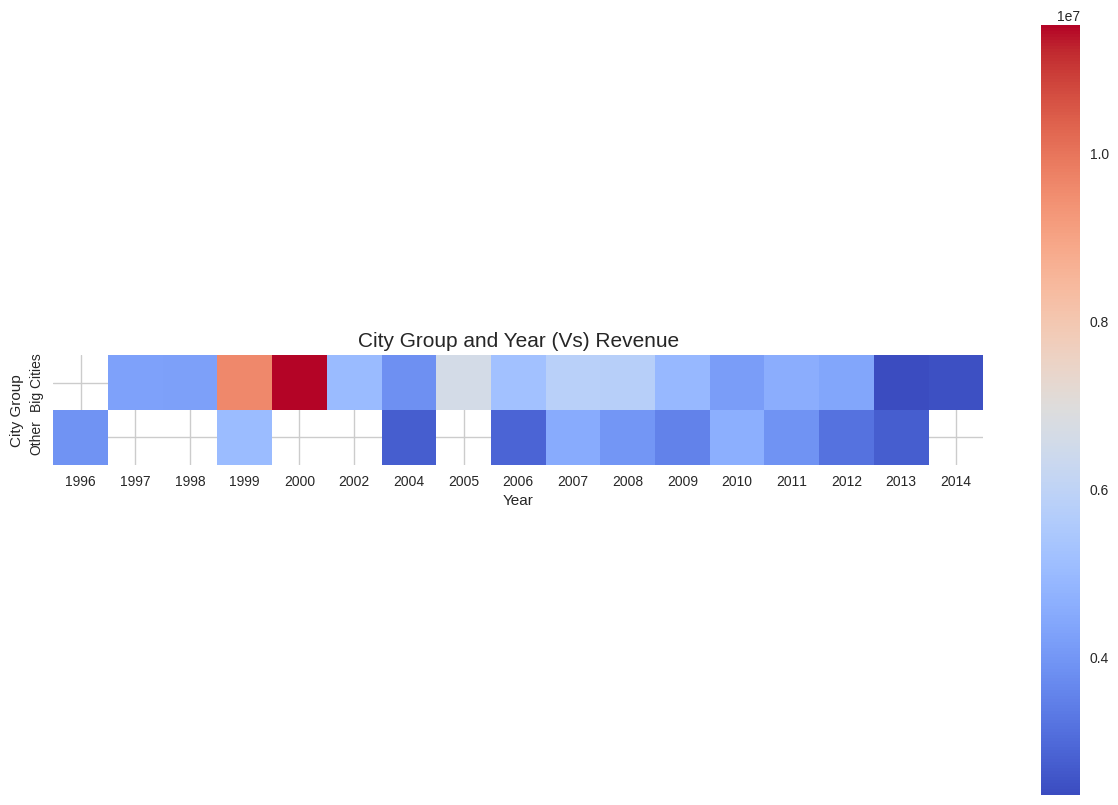

In [38]:
df = pd.DataFrame({'City Group':data['City Group'],'Year':data['Year'],'revenue':data['revenue']})

df_wide=df.pivot_table( index='City Group', columns='Year', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data in rect boxes
plt.title('City Group and Year (Vs) Revenue',size=15)
plt.show()

Nous pouvons observer que depuis 1997, quelques restaurants ouvrent chaque année dans les "grandes villes" et que les recettes ont été bonnes entre 1997 et 2012.

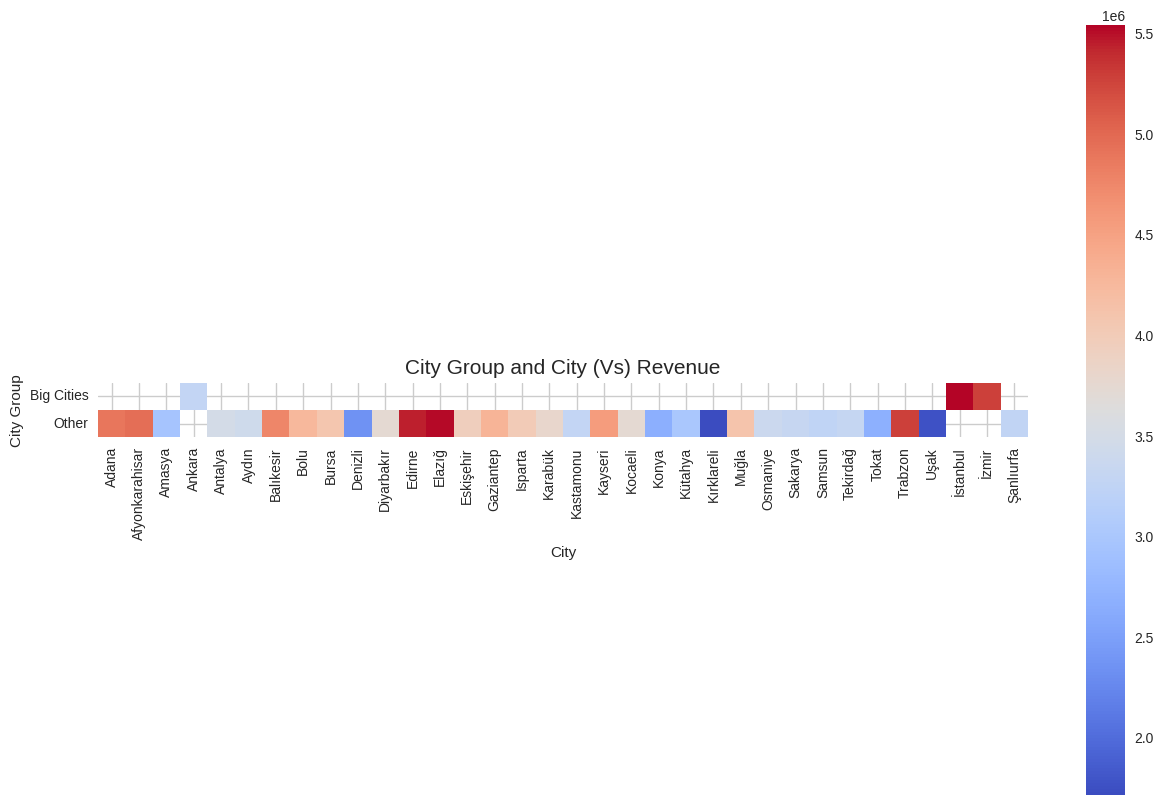

In [39]:
df = pd.DataFrame({'City Group':data['City Group'],'City':data['City'],'revenue':data['revenue']})

df_wide=df.pivot_table( index='City Group', columns='City', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data in rect boxes
plt.title('City Group and City (Vs) Revenue',size=15)
plt.show()

La principale information de ce graphique est qu'Ankara, Istanbul et Izmir sont les seules grandes villes.
Parmi les autres villes, Edime, Elazig et Trabzon fournissent des revenus plus élevés.

Text(0.5, 1.0, 'Type and City (Vs) Revenue')

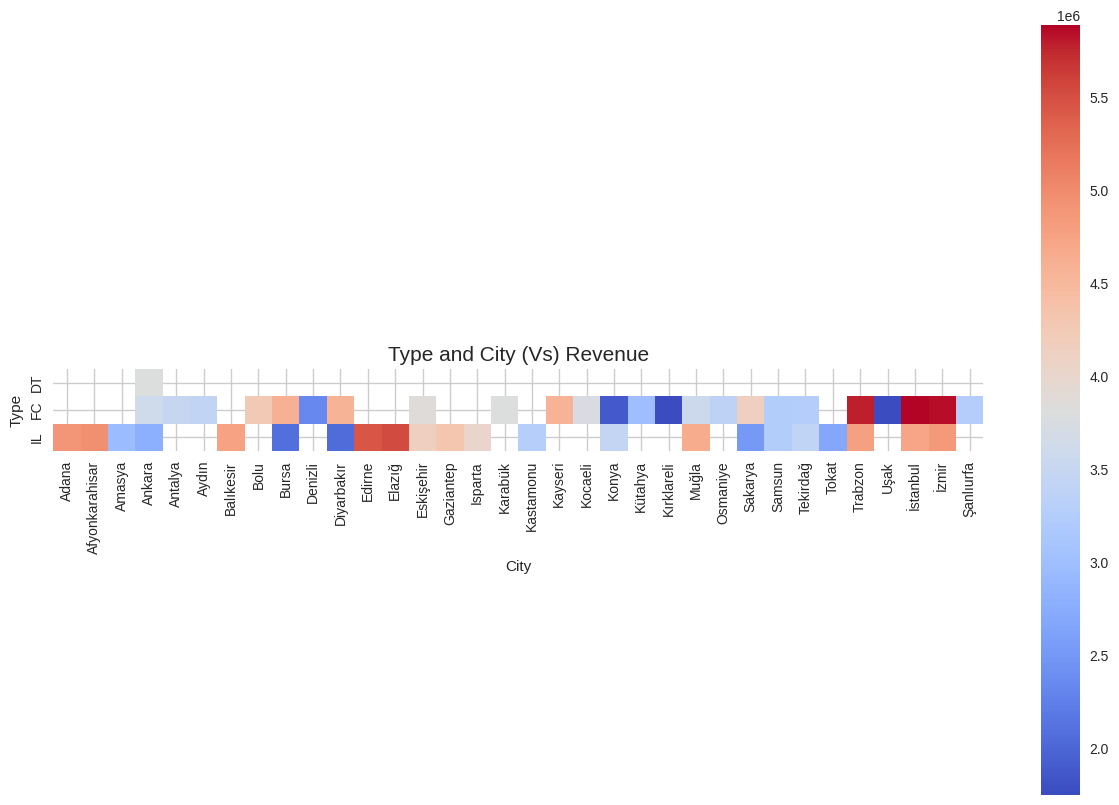

In [40]:
df = pd.DataFrame({'Type':data['Type'],'City':data['City'],'revenue':data['revenue']})

df_wide=df.pivot_table( index='Type', columns='City', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data in rect boxes
plt.title('Type and City (Vs) Revenue',size=15)

Dans les "grandes villes" comme Istanbul, Izmir et Ankara, la préférence peut être donnée aux restaurants de type "FC" (Food Court) afin de maximiser les revenus.

In [41]:
Path(REPORT_DIR).mkdir(parents=True, exist_ok=True)

profile = ProfileReport(data, title="House price - profiling")
# profile.to_notebook_iframe()
profile.to_file(Path(REPORT_DIR, 'profiling_report.html'))

Summarize dataset:  70%|██ | 988/1420 [02:48<00:56,  7.63it/s, scatter P20, P30]